## Basic Imports

In [ ]:
# !wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/segformers.zip && unzip segformers.zip
# !mv segformers/* .

In [ ]:
# !wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/segmentation.zip && unzip segmentation.zip

In [ ]:
# !mv segmentation/* .

In [ ]:
try:
    from einops import rearrange
    import segmentation_models_pytorch as smp
    from timm.models.layers import drop_path, trunc_normal_

except:
    !pip install timm
    !pip install einops
    !pip install segmentation-models-pytorch

    from einops import rearrange
    import segmentation_models_pytorch as smp
    from timm.models.layers import drop_path, trunc_normal_

In [ ]:
# basic imports
import numpy as np

# DL library imports
import torch
import torch.nn as nn
import torch.nn.functional as F

# libraries for loading image, plotting
import cv2
import matplotlib.pyplot as plt

## 1. Dataset: The BDD100k dataset

In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/Segmentation_CA_UNET"
output_path = 'dataset'

images = np.load("dataset/image_180_320.npy")
labels = np.load("dataset/label_180_320.npy")
print(images.shape)
print(labels.shape)

/content/drive/MyDrive/Colab Notebooks/Segmentation_CA_UNET
(3430, 180, 320, 3)
(3430, 180, 320)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


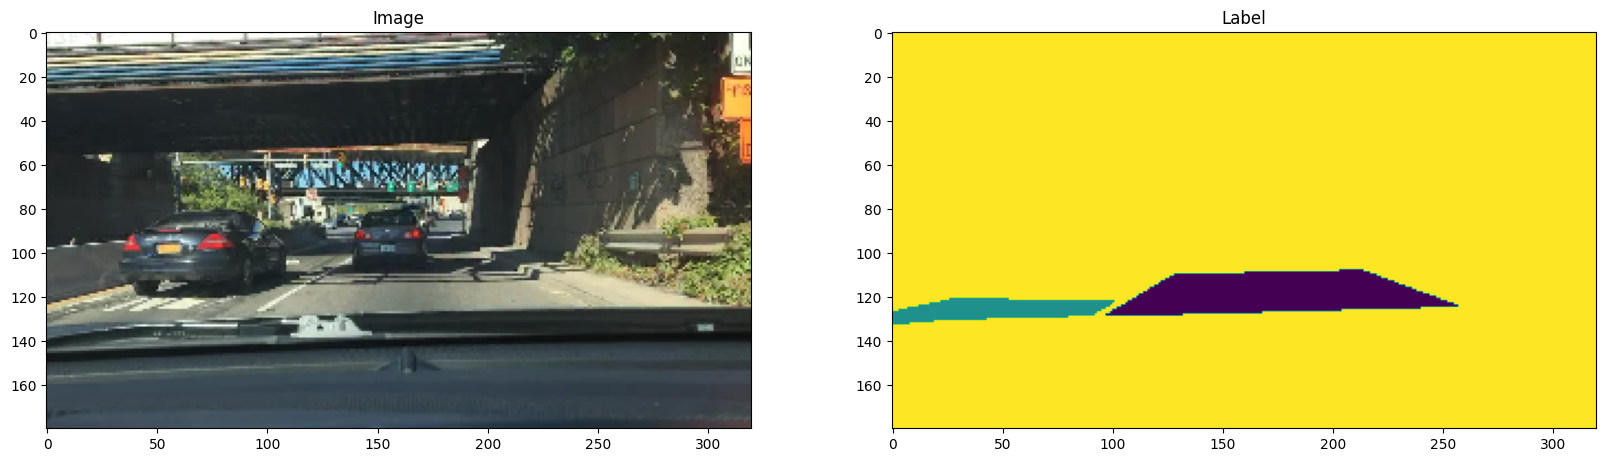

In [ ]:
f, (ax0, ax1) = plt.subplots(1,2, figsize=(20,40))
idx=316
ax0.imshow(images[idx])
ax0.set_title("Image")
ax1.imshow(labels[idx])
ax1.set_title("Label")
plt.show()

### Build Datasets & DataLoaders
Every PyTorch model is built and train using 3 elements:

*   Dataset
*   DataLoader
*   Model


In [ ]:
# utility functions to get BDD100k Pytorch dataset and dataloaders
from utils import get_datasets, get_dataloaders

train_set, val_set, test_set= get_datasets(images, labels)
sample_image, sample_label = train_set[0]
print(f"There are {len(train_set)} train images, {len(val_set)} validation images, {len(test_set)} test Images")
print(f"Input shape = {sample_image.shape}, output label shape = {sample_label.shape}")

train_dataloader, val_dataloader, test_dataloader = get_dataloaders(train_set, val_set, test_set)

There are 2401 train images, 686 validation images, 343 test Images
Input shape = torch.Size([3, 160, 320]), output label shape = torch.Size([160, 320])


## Show Sample images from dataset

In [ ]:
from collections import namedtuple

# Each label is a tuple with name, class id and color
Label = namedtuple( "Label", [ "name", "train_id", "color"])
drivables = [
             Label("direct", 0, (215, 40, 135)),        # red
             Label("alternative", 1, (61, 143, 86)),  # cyan
             Label("background", 2, (0, 0, 0)),        # black
            ]

train_id_to_color = [c.color for c in drivables if (c.train_id != -1 and c.train_id != 255)]
train_id_to_color = np.array(train_id_to_color)

torch.Size([3, 160, 320])
torch.Size([160, 320])


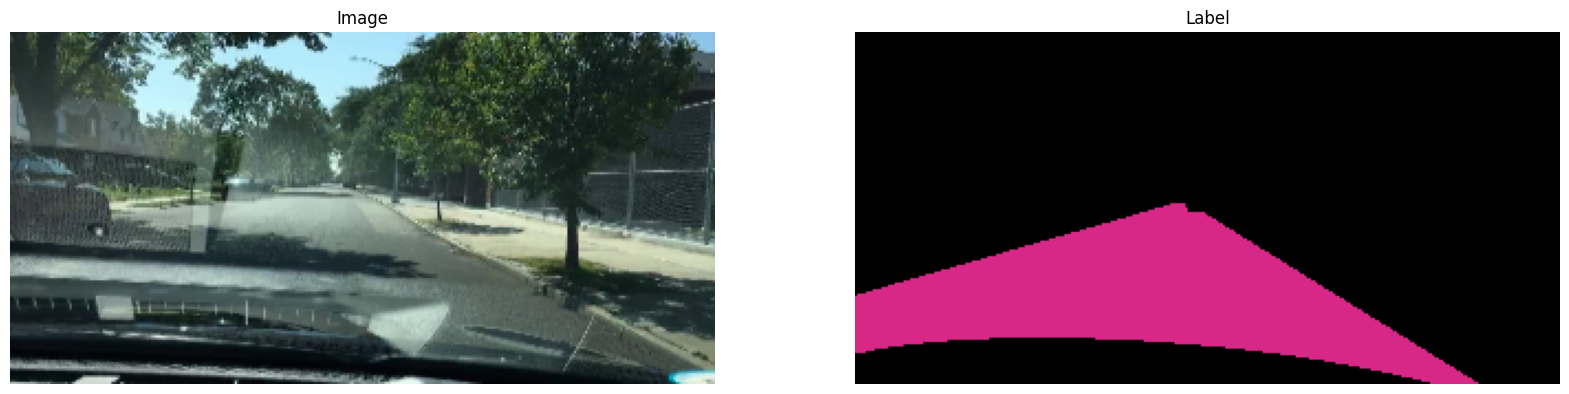

In [ ]:
from utils import inverse_transform

rgb_image, label = train_set[np.random.choice(len(train_set))]
print(rgb_image.shape)
print(label.shape)
rgb_image = inverse_transform(rgb_image).permute(1, 2, 0).cpu().detach().numpy()
label = label.cpu().detach().numpy()

# plot sample image
fig, axes = plt.subplots(1,2, figsize=(20,10))
axes[0].imshow(rgb_image);
axes[0].set_title("Image");
axes[0].axis('off');
axes[1].imshow(train_id_to_color[label]);
axes[1].set_title("Label");
axes[1].axis('off');

# Network : Define a Attention Based UNET

> Add blockquote




## 3. Training : Train and validate model on the custom dataset


We will reuse the utility functions we defined in UNet notebook

In [ ]:
from utils import meanIoU                  # metric class
from utils import plot_training_results    # function to plot training curves
from utils import evaluate_model           # evaluation function
from utils import train_validate_model     # train validate function
from model import AttentionUnet

## Model Training

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# MODEL HYPERPARAMETERS
N_EPOCHS = 150
NUM_CLASSES = 3
MAX_LR = 3e-4
MODEL_NAME = 'Attention Unet'

import os
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
criterion = smp.losses.DiceLoss('multiclass', classes=[0,1,2], log_loss = True, smooth=1.0)

# create model, load imagenet pretrained weights
model = AttentionUnet(img_ch=3, out_ch=NUM_CLASSES).to(device)
# backbone_weights = torch.load(os.path.join("weights", *['segformer_mit_b3_imagenet_weights.pt']))
# model.backbone.load_state_dict(backbone_weights)

Starting 1 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 1, trainLoss:1.14391, validationLoss:0.95376, meanIoU: 0.45
Starting 2 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.01it/s]


Epoch: 2, trainLoss:0.83896, validationLoss:0.77518, meanIoU: 0.50
Starting 3 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.02it/s]


Epoch: 3, trainLoss:0.70134, validationLoss:0.66341, meanIoU: 0.54
Starting 4 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.02it/s]


Epoch: 4, trainLoss:0.60296, validationLoss:0.60088, meanIoU: 0.57
Starting 5 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 5, trainLoss:0.53555, validationLoss:0.52695, meanIoU: 0.59
Starting 6 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 6, trainLoss:0.46551, validationLoss:0.53598, meanIoU: 0.60
Starting 7 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 7, trainLoss:0.40379, validationLoss:0.43393, meanIoU: 0.63
Starting 8 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 8, trainLoss:0.36639, validationLoss:0.44852, meanIoU: 0.62
Starting 9 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 9, trainLoss:0.33819, validationLoss:0.39719, meanIoU: 0.64
Starting 10 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.01it/s]


Epoch: 10, trainLoss:0.32810, validationLoss:0.50280, meanIoU: 0.62
Starting 11 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 11, trainLoss:0.30913, validationLoss:0.43460, meanIoU: 0.63
Starting 12 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.01it/s]


Epoch: 12, trainLoss:0.33999, validationLoss:0.49871, meanIoU: 0.59
Starting 13 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 13, trainLoss:0.33803, validationLoss:0.47567, meanIoU: 0.62
Starting 14 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 14, trainLoss:0.29364, validationLoss:0.43755, meanIoU: 0.64
Starting 15 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 15, trainLoss:0.28745, validationLoss:0.36873, meanIoU: 0.65
Starting 16 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 16, trainLoss:0.26202, validationLoss:0.43190, meanIoU: 0.63
Starting 17 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 17, trainLoss:0.26328, validationLoss:0.41631, meanIoU: 0.65
Starting 18 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 18, trainLoss:0.24884, validationLoss:0.51448, meanIoU: 0.63
Starting 19 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.01it/s]


Epoch: 19, trainLoss:0.24675, validationLoss:0.50048, meanIoU: 0.64
Starting 20 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.01it/s]


Epoch: 20, trainLoss:0.24075, validationLoss:0.38386, meanIoU: 0.64
Starting 21 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 21, trainLoss:0.24116, validationLoss:0.37376, meanIoU: 0.66
Starting 22 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.01it/s]


Epoch: 22, trainLoss:0.24500, validationLoss:0.40826, meanIoU: 0.66
Starting 23 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 23, trainLoss:0.24397, validationLoss:0.40026, meanIoU: 0.66
Starting 24 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 24, trainLoss:0.23265, validationLoss:0.47192, meanIoU: 0.63
Starting 25 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 25, trainLoss:0.22095, validationLoss:0.43658, meanIoU: 0.65
Starting 26 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.01it/s]


Epoch: 26, trainLoss:0.23259, validationLoss:0.36303, meanIoU: 0.65
Starting 27 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 27, trainLoss:0.21599, validationLoss:0.41216, meanIoU: 0.65
Starting 28 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 28, trainLoss:0.22761, validationLoss:0.41577, meanIoU: 0.65
Starting 29 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 29, trainLoss:0.21468, validationLoss:0.43417, meanIoU: 0.65
Starting 30 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 30, trainLoss:0.20842, validationLoss:0.46998, meanIoU: 0.66
Starting 31 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.01it/s]


Epoch: 31, trainLoss:0.20473, validationLoss:0.52329, meanIoU: 0.63
Starting 32 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 32, trainLoss:0.20183, validationLoss:0.40200, meanIoU: 0.68
Starting 33 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 33, trainLoss:0.18432, validationLoss:0.46176, meanIoU: 0.67
Starting 34 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 34, trainLoss:0.18359, validationLoss:0.35986, meanIoU: 0.68
Starting 35 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.03it/s]


Epoch: 35, trainLoss:0.18790, validationLoss:0.58124, meanIoU: 0.64
Starting 36 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.01it/s]


Epoch: 36, trainLoss:0.18138, validationLoss:0.38884, meanIoU: 0.67
Starting 37 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.01it/s]


Epoch: 37, trainLoss:0.18622, validationLoss:0.52032, meanIoU: 0.64
Starting 38 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 38, trainLoss:0.17375, validationLoss:0.34574, meanIoU: 0.68
Starting 39 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 39, trainLoss:0.17029, validationLoss:0.35264, meanIoU: 0.68
Starting 40 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.01it/s]


Epoch: 40, trainLoss:0.16426, validationLoss:0.34189, meanIoU: 0.69
Starting 41 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 41, trainLoss:0.15429, validationLoss:0.31969, meanIoU: 0.69
Starting 42 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 42, trainLoss:0.14674, validationLoss:0.36430, meanIoU: 0.68
Starting 43 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.03it/s]


Epoch: 43, trainLoss:0.15957, validationLoss:0.36547, meanIoU: 0.69
Starting 44 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.02it/s]


Epoch: 44, trainLoss:0.14997, validationLoss:0.36775, meanIoU: 0.68
Starting 45 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.01it/s]


Epoch: 45, trainLoss:0.14571, validationLoss:0.30359, meanIoU: 0.67
Starting 46 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.01it/s]


Epoch: 46, trainLoss:0.15869, validationLoss:0.43546, meanIoU: 0.67
Starting 47 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.01it/s]


Epoch: 47, trainLoss:0.15734, validationLoss:0.44940, meanIoU: 0.69
Starting 48 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.01it/s]


Epoch: 48, trainLoss:0.12983, validationLoss:0.41031, meanIoU: 0.66
Starting 49 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.01it/s]


Epoch: 49, trainLoss:0.14200, validationLoss:0.44448, meanIoU: 0.68
Starting 50 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.01it/s]


Epoch: 50, trainLoss:0.13322, validationLoss:0.47937, meanIoU: 0.67
Starting 51 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 51, trainLoss:0.11779, validationLoss:0.32970, meanIoU: 0.69
Starting 52 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 52, trainLoss:0.11064, validationLoss:0.35811, meanIoU: 0.70
Starting 53 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 53, trainLoss:0.11588, validationLoss:0.33828, meanIoU: 0.69
Starting 54 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.98it/s]


Epoch: 54, trainLoss:0.12322, validationLoss:0.37078, meanIoU: 0.69
Starting 55 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 55, trainLoss:0.11291, validationLoss:0.37904, meanIoU: 0.69
Starting 56 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 56, trainLoss:0.11109, validationLoss:0.41279, meanIoU: 0.68
Starting 57 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.02it/s]


Epoch: 57, trainLoss:0.11117, validationLoss:0.50258, meanIoU: 0.67
Starting 58 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 58, trainLoss:0.09827, validationLoss:0.38234, meanIoU: 0.69
Starting 59 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.01it/s]


Epoch: 59, trainLoss:0.09793, validationLoss:0.37477, meanIoU: 0.69
Starting 60 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 60, trainLoss:0.09995, validationLoss:0.32797, meanIoU: 0.70
Starting 61 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.98it/s]


Epoch: 61, trainLoss:0.10972, validationLoss:0.36578, meanIoU: 0.69
Starting 62 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.98it/s]


Epoch: 62, trainLoss:0.10901, validationLoss:0.37961, meanIoU: 0.69
Starting 63 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 63, trainLoss:0.10645, validationLoss:0.39458, meanIoU: 0.69
Starting 64 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.02it/s]


Epoch: 64, trainLoss:0.09535, validationLoss:0.37511, meanIoU: 0.70
Starting 65 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 65, trainLoss:0.08436, validationLoss:0.38854, meanIoU: 0.70
Starting 66 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.01it/s]


Epoch: 66, trainLoss:0.08439, validationLoss:0.39921, meanIoU: 0.69
Starting 67 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.01it/s]


Epoch: 67, trainLoss:0.08476, validationLoss:0.34414, meanIoU: 0.70
Starting 68 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 68, trainLoss:0.07646, validationLoss:0.36603, meanIoU: 0.71
Starting 69 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.01it/s]


Epoch: 69, trainLoss:0.07444, validationLoss:0.34954, meanIoU: 0.70
Starting 70 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 70, trainLoss:0.07659, validationLoss:0.33658, meanIoU: 0.70
Starting 71 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 71, trainLoss:0.07486, validationLoss:0.36036, meanIoU: 0.71
Starting 72 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.01it/s]


Epoch: 72, trainLoss:0.09396, validationLoss:0.44778, meanIoU: 0.68
Starting 73 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 73, trainLoss:0.08242, validationLoss:0.28841, meanIoU: 0.71
Starting 74 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.02it/s]


Epoch: 74, trainLoss:0.07641, validationLoss:0.37037, meanIoU: 0.70
Starting 75 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 75, trainLoss:0.07972, validationLoss:0.42701, meanIoU: 0.69
Starting 76 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 76, trainLoss:0.07087, validationLoss:0.38326, meanIoU: 0.71
Starting 77 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 77, trainLoss:0.06414, validationLoss:0.39071, meanIoU: 0.70
Starting 78 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.98it/s]


Epoch: 78, trainLoss:0.06166, validationLoss:0.38456, meanIoU: 0.71
Starting 79 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 79, trainLoss:0.05947, validationLoss:0.37422, meanIoU: 0.70
Starting 80 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 80, trainLoss:0.05696, validationLoss:0.41353, meanIoU: 0.70
Starting 81 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.98it/s]


Epoch: 81, trainLoss:0.05826, validationLoss:0.39816, meanIoU: 0.71
Starting 82 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 82, trainLoss:0.05647, validationLoss:0.32911, meanIoU: 0.71
Starting 83 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 83, trainLoss:0.05633, validationLoss:0.38695, meanIoU: 0.70
Starting 84 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 84, trainLoss:0.05532, validationLoss:0.41690, meanIoU: 0.70
Starting 85 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.01it/s]


Epoch: 85, trainLoss:0.05585, validationLoss:0.37894, meanIoU: 0.70
Starting 86 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 86, trainLoss:0.05569, validationLoss:0.39818, meanIoU: 0.70
Starting 87 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 87, trainLoss:0.05673, validationLoss:0.37186, meanIoU: 0.70
Starting 88 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 88, trainLoss:0.05980, validationLoss:0.37749, meanIoU: 0.70
Starting 89 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.01it/s]


Epoch: 89, trainLoss:0.05047, validationLoss:0.35693, meanIoU: 0.71
Starting 90 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 90, trainLoss:0.04701, validationLoss:0.34721, meanIoU: 0.71
Starting 91 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.01it/s]


Epoch: 91, trainLoss:0.04582, validationLoss:0.36059, meanIoU: 0.71
Starting 92 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 92, trainLoss:0.04753, validationLoss:0.36845, meanIoU: 0.71
Starting 93 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 93, trainLoss:0.04804, validationLoss:0.34829, meanIoU: 0.71
Starting 94 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 94, trainLoss:0.04420, validationLoss:0.38460, meanIoU: 0.70
Starting 95 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.01it/s]


Epoch: 95, trainLoss:0.04251, validationLoss:0.37739, meanIoU: 0.70
Starting 96 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 96, trainLoss:0.04149, validationLoss:0.37327, meanIoU: 0.70
Starting 97 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 97, trainLoss:0.04193, validationLoss:0.36799, meanIoU: 0.70
Starting 98 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.02it/s]


Epoch: 98, trainLoss:0.04075, validationLoss:0.40345, meanIoU: 0.70
Starting 99 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.02it/s]


Epoch: 99, trainLoss:0.04899, validationLoss:0.35606, meanIoU: 0.70
Starting 100 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.01it/s]


Epoch: 100, trainLoss:0.04120, validationLoss:0.33220, meanIoU: 0.71
Starting 101 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.01it/s]


Epoch: 101, trainLoss:0.03892, validationLoss:0.34629, meanIoU: 0.71
Starting 102 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 102, trainLoss:0.03701, validationLoss:0.33674, meanIoU: 0.71
Starting 103 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 103, trainLoss:0.03638, validationLoss:0.34450, meanIoU: 0.71
Starting 104 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 104, trainLoss:0.03634, validationLoss:0.42293, meanIoU: 0.68
Starting 105 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.01it/s]


Epoch: 105, trainLoss:0.03870, validationLoss:0.37439, meanIoU: 0.70
Starting 106 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 106, trainLoss:0.03657, validationLoss:0.31608, meanIoU: 0.71
Starting 107 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 107, trainLoss:0.03469, validationLoss:0.34373, meanIoU: 0.71
Starting 108 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.02it/s]


Epoch: 108, trainLoss:0.03384, validationLoss:0.31719, meanIoU: 0.71
Starting 109 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.01it/s]


Epoch: 109, trainLoss:0.03346, validationLoss:0.34242, meanIoU: 0.71
Starting 110 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.01it/s]


Epoch: 110, trainLoss:0.03272, validationLoss:0.29604, meanIoU: 0.71
Starting 111 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.02it/s]


Epoch: 111, trainLoss:0.03213, validationLoss:0.31243, meanIoU: 0.71
Starting 112 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.02it/s]


Epoch: 112, trainLoss:0.03162, validationLoss:0.31526, meanIoU: 0.71
Starting 113 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.01it/s]


Epoch: 113, trainLoss:0.03156, validationLoss:0.31286, meanIoU: 0.71
Starting 114 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 114, trainLoss:0.03122, validationLoss:0.35940, meanIoU: 0.71
Starting 115 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 115, trainLoss:0.03074, validationLoss:0.34115, meanIoU: 0.72
Starting 116 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.97it/s]


Epoch: 116, trainLoss:0.03000, validationLoss:0.33090, meanIoU: 0.71
Starting 117 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 117, trainLoss:0.02985, validationLoss:0.34692, meanIoU: 0.71
Starting 118 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.98it/s]


Epoch: 118, trainLoss:0.02933, validationLoss:0.35526, meanIoU: 0.71
Starting 119 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 119, trainLoss:0.02873, validationLoss:0.34361, meanIoU: 0.71
Starting 120 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 120, trainLoss:0.02844, validationLoss:0.34092, meanIoU: 0.71
Starting 121 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 121, trainLoss:0.02765, validationLoss:0.31083, meanIoU: 0.71
Starting 122 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 122, trainLoss:0.02747, validationLoss:0.31790, meanIoU: 0.71
Starting 123 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.98it/s]


Epoch: 123, trainLoss:0.02673, validationLoss:0.31387, meanIoU: 0.71
Starting 124 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 124, trainLoss:0.02657, validationLoss:0.29845, meanIoU: 0.71
Starting 125 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 125, trainLoss:0.02587, validationLoss:0.33162, meanIoU: 0.71
Starting 126 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.98it/s]


Epoch: 126, trainLoss:0.02578, validationLoss:0.31261, meanIoU: 0.72
Starting 127 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 127, trainLoss:0.02546, validationLoss:0.31989, meanIoU: 0.71
Starting 128 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.01it/s]


Epoch: 128, trainLoss:0.02513, validationLoss:0.27332, meanIoU: 0.71
Starting 129 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 129, trainLoss:0.02492, validationLoss:0.29404, meanIoU: 0.71
Starting 130 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 130, trainLoss:0.02468, validationLoss:0.31999, meanIoU: 0.72
Starting 131 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 131, trainLoss:0.02431, validationLoss:0.29541, meanIoU: 0.72
Starting 132 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 132, trainLoss:0.02414, validationLoss:0.31680, meanIoU: 0.71
Starting 133 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 133, trainLoss:0.02399, validationLoss:0.33761, meanIoU: 0.71
Starting 134 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.01it/s]


Epoch: 134, trainLoss:0.02364, validationLoss:0.32043, meanIoU: 0.71
Starting 135 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 135, trainLoss:0.02353, validationLoss:0.30619, meanIoU: 0.71
Starting 136 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 136, trainLoss:0.02338, validationLoss:0.33764, meanIoU: 0.72
Starting 137 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.97it/s]


Epoch: 137, trainLoss:0.02327, validationLoss:0.31907, meanIoU: 0.71
Starting 138 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 138, trainLoss:0.02310, validationLoss:0.34858, meanIoU: 0.71
Starting 139 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 139, trainLoss:0.02296, validationLoss:0.31767, meanIoU: 0.71
Starting 140 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 140, trainLoss:0.02280, validationLoss:0.31128, meanIoU: 0.72
Starting 141 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 141, trainLoss:0.02276, validationLoss:0.32500, meanIoU: 0.72
Starting 142 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 142, trainLoss:0.02265, validationLoss:0.31208, meanIoU: 0.71
Starting 143 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.98it/s]


Epoch: 143, trainLoss:0.02268, validationLoss:0.31201, meanIoU: 0.72
Starting 144 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 144, trainLoss:0.02263, validationLoss:0.30564, meanIoU: 0.71
Starting 145 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 145, trainLoss:0.02255, validationLoss:0.30562, meanIoU: 0.71
Starting 146 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.97it/s]


Epoch: 146, trainLoss:0.02255, validationLoss:0.31115, meanIoU: 0.71
Starting 147 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.02it/s]


Epoch: 147, trainLoss:0.02249, validationLoss:0.33210, meanIoU: 0.71
Starting 148 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.00it/s]


Epoch: 148, trainLoss:0.02249, validationLoss:0.30295, meanIoU: 0.72
Starting 149 epoch ...


100%|██████████| 86/86 [00:21<00:00,  3.99it/s]


Epoch: 149, trainLoss:0.02251, validationLoss:0.34542, meanIoU: 0.71
Starting 150 epoch ...


100%|██████████| 86/86 [00:21<00:00,  4.01it/s]


Epoch: 150, trainLoss:0.02246, validationLoss:0.31687, meanIoU: 0.71


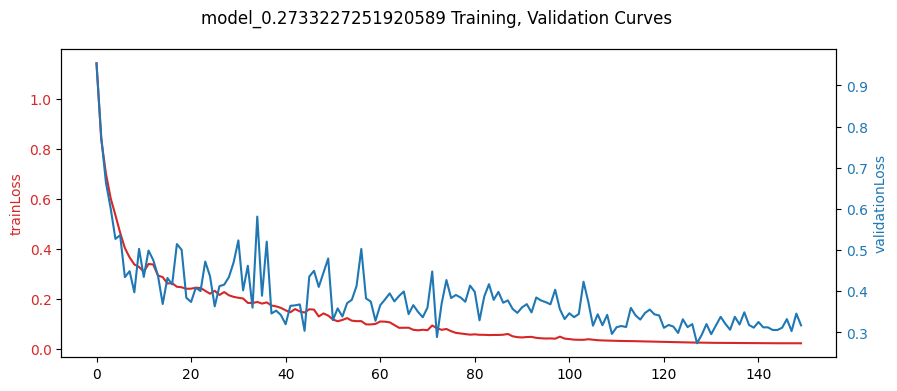

In [ ]:
# create optimizer, lr_scheduler and pass to training function
model = AttentionUnet(img_ch=3, out_ch=NUM_CLASSES).to(device)
optimizer = optim.Adam(model.parameters(), lr=MAX_LR)
scheduler = OneCycleLR(optimizer, max_lr= MAX_LR, epochs = N_EPOCHS,steps_per_epoch = len(train_dataloader),
                       pct_start=0.3, div_factor=10, anneal_strategy='cos')

model,results = train_validate_model(model, N_EPOCHS, MODEL_NAME, criterion, optimizer,
                         device, train_dataloader, val_dataloader, meanIoU, 'meanIoU',
                         NUM_CLASSES, lr_scheduler = scheduler, output_path = output_path)

In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/Segmentation_CA_UNET"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from model import AttentionUnet
output_path = "models_trained"
model_name = "model_trained"
state_dict = torch.load(f"{output_path}/{model_name}.pt")
model1 = AttentionUnet(img_ch=3, out_ch=3).to(device)
model1.load_state_dict(state_dict)



/content/drive/MyDrive/Colab Notebooks/Segmentation_CA_UNET


<All keys matched successfully>

## 4. Evaluate : Evaluate the model on Test Data and visualize results

In [ ]:

# model.load_state_dict(torch.load(f'weights/{MODEL_NAME}.pt', map_location=device))
_, test_metric = evaluate_model(model1, test_dataloader, criterion, meanIoU, NUM_CLASSES, device)
print(f"\nModel has {test_metric} mean IoU in test set")

100%|██████████| 43/43 [00:10<00:00,  4.14it/s]


Model has 0.7428219189403031 mean IoU in test set


In [ ]:
from utils import visualize_predictions
num_test_samples = 2
_, axes = plt.subplots(num_test_samples, 3, figsize=(3*6, num_test_samples * 4))
visualize_predictions(model1, test_set, axes, device, numTestSamples=num_test_samples, id_to_color =train_id_to_color)

## Test on sample video
If you want to test it on a real video, you can try:

```python
from utils import predict_video
predict_video(model, model_name, input_video_path, output_dir,
            target_width, target_height, device)
```

In out case, we'll have several videos we can try our model on:
* Highway (KITTI)<p>
`!wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/highway_1241_376.avi`
* Residential (KITTI)<p>
`!wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/residential_1242_375.avi`
* Campus (KITTI)<p>
`!wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/campus_1224_370.avi`
* Stuttgart (Cityscapes)<p>
`!wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/stuttgart_1024_512.avi`


In [ ]:
!wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/highway_1241_376.avi

--2024-06-20 23:27:58--  https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/highway_1241_376.avi
Resolving thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com (thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com)... 52.95.154.90, 16.12.20.22
Connecting to thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com (thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com)|52.95.154.90|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55440936 (53M) [video/x-msvideo]
Saving to: ‘highway_1241_376.avi’

highway_1241_376.av 100%[===================>]  52.87M  58.9MB/s    in 0.9s    

2024-06-20 23:27:59 (58.9 MB/s) - ‘highway_1241_376.avi’ saved [55440936/55440936]



In [ ]:
from utils import predict_video
# !pip install opencv-python
import cv2
predict_video(model1, "SegFormer5epochs", "highway_1241_376.avi", "models_trained", 1241, 376, "cuda", train_id_to_color)

  0%|          | 2/1170 [00:00<01:07, 17.28it/s]

pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


  1%|          | 7/1170 [00:00<00:57, 20.05it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


  1%|          | 13/1170 [00:00<00:47, 24.19it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


  2%|▏         | 19/1170 [00:00<00:43, 26.17it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


  2%|▏         | 25/1170 [00:01<00:42, 27.21it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


  3%|▎         | 31/1170 [00:01<00:40, 27.79it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


  3%|▎         | 37/1170 [00:01<00:40, 27.93it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


  4%|▎         | 43/1170 [00:01<00:40, 27.95it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


  4%|▍         | 49/1170 [00:01<00:40, 27.83it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


  5%|▍         | 55/1170 [00:02<00:40, 27.66it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


  5%|▌         | 61/1170 [00:02<00:40, 27.18it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)


  6%|▌         | 67/1170 [00:02<00:40, 27.27it/s]

pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


  6%|▌         | 73/1170 [00:02<00:40, 27.32it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


  7%|▋         | 79/1170 [00:02<00:39, 27.30it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


  7%|▋         | 85/1170 [00:03<00:39, 27.50it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


  8%|▊         | 91/1170 [00:03<00:39, 27.30it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


  8%|▊         | 97/1170 [00:03<00:39, 27.50it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


  9%|▉         | 103/1170 [00:03<00:39, 27.33it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


  9%|▉         | 109/1170 [00:04<00:38, 27.64it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 10%|▉         | 115/1170 [00:04<00:38, 27.29it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 10%|█         | 121/1170 [00:04<00:37, 27.63it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 11%|█         | 127/1170 [00:04<00:38, 27.40it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 11%|█▏        | 133/1170 [00:04<00:38, 27.25it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 12%|█▏        | 139/1170 [00:05<00:37, 27.36it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 12%|█▏        | 145/1170 [00:05<00:36, 27.75it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 13%|█▎        | 151/1170 [00:05<00:37, 27.48it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 13%|█▎        | 157/1170 [00:05<00:36, 27.57it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 14%|█▍        | 163/1170 [00:06<00:36, 27.46it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 14%|█▍        | 169/1170 [00:06<00:36, 27.47it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 15%|█▍        | 175/1170 [00:06<00:36, 27.60it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 15%|█▌        | 181/1170 [00:06<00:36, 27.41it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 16%|█▌        | 187/1170 [00:06<00:35, 27.36it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 16%|█▋        | 193/1170 [00:07<00:36, 27.02it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)


 17%|█▋        | 196/1170 [00:07<00:36, 26.74it/s]

pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 17%|█▋        | 202/1170 [00:07<00:35, 27.02it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)


 18%|█▊        | 208/1170 [00:07<00:36, 26.48it/s]

pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 18%|█▊        | 214/1170 [00:07<00:34, 27.37it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 19%|█▉        | 220/1170 [00:08<00:33, 28.20it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 19%|█▉        | 226/1170 [00:08<00:32, 28.61it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 20%|█▉        | 232/1170 [00:08<00:32, 28.82it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 20%|██        | 238/1170 [00:08<00:32, 28.86it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 21%|██        | 244/1170 [00:08<00:32, 28.92it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 21%|██▏       | 250/1170 [00:09<00:31, 28.76it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 22%|██▏       | 256/1170 [00:09<00:31, 28.86it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 22%|██▏       | 262/1170 [00:09<00:31, 29.09it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 23%|██▎       | 268/1170 [00:09<00:31, 29.09it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 23%|██▎       | 274/1170 [00:09<00:30, 28.99it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 24%|██▍       | 280/1170 [00:10<00:30, 29.16it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 24%|██▍       | 286/1170 [00:10<00:30, 29.02it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 25%|██▍       | 292/1170 [00:10<00:30, 29.17it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 25%|██▌       | 298/1170 [00:10<00:29, 29.10it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 26%|██▌       | 304/1170 [00:11<00:29, 29.22it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 26%|██▋       | 310/1170 [00:11<00:29, 29.02it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 27%|██▋       | 316/1170 [00:11<00:29, 29.08it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 28%|██▊       | 323/1170 [00:11<00:28, 29.64it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 28%|██▊       | 329/1170 [00:11<00:28, 29.10it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 29%|██▊       | 335/1170 [00:12<00:28, 29.18it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 29%|██▉       | 341/1170 [00:12<00:28, 29.20it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 30%|██▉       | 347/1170 [00:12<00:28, 29.17it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 30%|███       | 353/1170 [00:12<00:28, 29.17it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 31%|███       | 359/1170 [00:12<00:27, 29.10it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 31%|███       | 365/1170 [00:13<00:27, 29.10it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 32%|███▏      | 371/1170 [00:13<00:27, 28.94it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 32%|███▏      | 377/1170 [00:13<00:27, 29.11it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 33%|███▎      | 383/1170 [00:13<00:27, 28.92it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 33%|███▎      | 389/1170 [00:13<00:27, 28.84it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 34%|███▍      | 395/1170 [00:14<00:26, 28.98it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 34%|███▍      | 401/1170 [00:14<00:26, 28.87it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 35%|███▍      | 407/1170 [00:14<00:26, 28.93it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 35%|███▌      | 413/1170 [00:14<00:26, 28.97it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 36%|███▌      | 419/1170 [00:14<00:25, 29.11it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 36%|███▋      | 425/1170 [00:15<00:25, 28.92it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 37%|███▋      | 431/1170 [00:15<00:25, 28.86it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 37%|███▋      | 437/1170 [00:15<00:25, 28.94it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 38%|███▊      | 443/1170 [00:15<00:25, 28.90it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 38%|███▊      | 449/1170 [00:16<00:25, 28.62it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 39%|███▉      | 455/1170 [00:16<00:25, 28.43it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 39%|███▉      | 461/1170 [00:16<00:24, 28.64it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 40%|███▉      | 467/1170 [00:16<00:24, 28.38it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 40%|████      | 473/1170 [00:16<00:24, 28.52it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 41%|████      | 479/1170 [00:17<00:24, 28.49it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 41%|████▏     | 485/1170 [00:17<00:23, 28.67it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 42%|████▏     | 491/1170 [00:17<00:23, 28.42it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 42%|████▏     | 497/1170 [00:17<00:23, 28.52it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 43%|████▎     | 503/1170 [00:17<00:23, 28.18it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 44%|████▎     | 509/1170 [00:18<00:23, 28.25it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 44%|████▍     | 515/1170 [00:18<00:23, 27.95it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 45%|████▍     | 521/1170 [00:18<00:23, 27.55it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 45%|████▌     | 527/1170 [00:18<00:23, 27.67it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 46%|████▌     | 533/1170 [00:18<00:22, 27.78it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 46%|████▌     | 539/1170 [00:19<00:22, 27.72it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 47%|████▋     | 545/1170 [00:19<00:22, 28.10it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 47%|████▋     | 551/1170 [00:19<00:22, 27.55it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 48%|████▊     | 557/1170 [00:19<00:22, 27.27it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 48%|████▊     | 563/1170 [00:20<00:22, 27.21it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 49%|████▊     | 569/1170 [00:20<00:22, 27.00it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)


 49%|████▉     | 572/1170 [00:20<00:22, 27.08it/s]

pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)


 49%|████▉     | 578/1170 [00:20<00:21, 27.58it/s]

pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)


 50%|████▉     | 584/1170 [00:20<00:21, 27.43it/s]

pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 50%|█████     | 590/1170 [00:21<00:21, 27.59it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 51%|█████     | 596/1170 [00:21<00:20, 27.76it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 51%|█████▏    | 602/1170 [00:21<00:20, 27.82it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 52%|█████▏    | 608/1170 [00:21<00:20, 28.05it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 52%|█████▏    | 614/1170 [00:21<00:19, 27.94it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 53%|█████▎    | 620/1170 [00:22<00:19, 27.96it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 54%|█████▎    | 626/1170 [00:22<00:19, 28.06it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 54%|█████▍    | 632/1170 [00:22<00:19, 28.23it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 55%|█████▍    | 638/1170 [00:22<00:18, 28.41it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 55%|█████▌    | 644/1170 [00:22<00:18, 28.20it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 56%|█████▌    | 650/1170 [00:23<00:18, 28.37it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 56%|█████▌    | 656/1170 [00:23<00:18, 27.86it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 57%|█████▋    | 662/1170 [00:23<00:18, 28.07it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 57%|█████▋    | 668/1170 [00:23<00:17, 28.17it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 58%|█████▊    | 674/1170 [00:24<00:17, 28.14it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 58%|█████▊    | 680/1170 [00:24<00:17, 28.18it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 59%|█████▊    | 686/1170 [00:24<00:17, 28.45it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 59%|█████▉    | 692/1170 [00:24<00:16, 28.36it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 60%|█████▉    | 698/1170 [00:24<00:16, 28.50it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 60%|██████    | 704/1170 [00:25<00:16, 28.29it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 61%|██████    | 710/1170 [00:25<00:16, 28.46it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 61%|██████    | 716/1170 [00:25<00:15, 28.49it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 62%|██████▏   | 722/1170 [00:25<00:15, 28.54it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 62%|██████▏   | 728/1170 [00:25<00:15, 28.19it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 63%|██████▎   | 734/1170 [00:26<00:15, 28.28it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 63%|██████▎   | 740/1170 [00:26<00:15, 28.26it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 64%|██████▍   | 746/1170 [00:26<00:14, 28.43it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 64%|██████▍   | 752/1170 [00:26<00:14, 28.57it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 65%|██████▍   | 758/1170 [00:27<00:14, 28.69it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 65%|██████▌   | 764/1170 [00:27<00:14, 28.57it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 66%|██████▌   | 770/1170 [00:27<00:13, 28.61it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 66%|██████▋   | 776/1170 [00:27<00:13, 28.63it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 67%|██████▋   | 782/1170 [00:27<00:13, 28.56it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 67%|██████▋   | 788/1170 [00:28<00:13, 28.64it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 68%|██████▊   | 794/1170 [00:28<00:13, 28.42it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 68%|██████▊   | 800/1170 [00:28<00:12, 28.52it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 69%|██████▉   | 806/1170 [00:28<00:12, 28.46it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 69%|██████▉   | 812/1170 [00:28<00:12, 28.45it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 70%|██████▉   | 818/1170 [00:29<00:12, 28.56it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 70%|███████   | 824/1170 [00:29<00:12, 28.51it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 71%|███████   | 830/1170 [00:29<00:11, 28.64it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 71%|███████▏  | 836/1170 [00:29<00:11, 28.61it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 72%|███████▏  | 842/1170 [00:29<00:11, 28.81it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 72%|███████▏  | 848/1170 [00:30<00:11, 28.40it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 73%|███████▎  | 854/1170 [00:30<00:11, 28.24it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 74%|███████▎  | 860/1170 [00:30<00:11, 27.55it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 74%|███████▍  | 866/1170 [00:30<00:11, 27.55it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 75%|███████▍  | 872/1170 [00:31<00:10, 27.35it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 75%|███████▌  | 878/1170 [00:31<00:10, 27.50it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 76%|███████▌  | 884/1170 [00:31<00:10, 27.32it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 76%|███████▌  | 890/1170 [00:31<00:10, 27.28it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 77%|███████▋  | 896/1170 [00:31<00:10, 27.04it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 77%|███████▋  | 902/1170 [00:32<00:09, 26.96it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 78%|███████▊  | 908/1170 [00:32<00:09, 26.47it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)


 78%|███████▊  | 914/1170 [00:32<00:09, 26.26it/s]

pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 79%|███████▊  | 920/1170 [00:32<00:09, 26.16it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)


 79%|███████▉  | 926/1170 [00:33<00:09, 26.76it/s]

pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 80%|███████▉  | 932/1170 [00:33<00:08, 26.98it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 80%|████████  | 938/1170 [00:33<00:08, 27.34it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 81%|████████  | 944/1170 [00:33<00:08, 27.25it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 81%|████████  | 950/1170 [00:33<00:08, 27.42it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 82%|████████▏ | 956/1170 [00:34<00:07, 27.13it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 82%|████████▏ | 962/1170 [00:34<00:07, 26.84it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 83%|████████▎ | 968/1170 [00:34<00:07, 27.12it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 83%|████████▎ | 974/1170 [00:34<00:07, 27.00it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 84%|████████▍ | 980/1170 [00:35<00:07, 26.79it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 84%|████████▍ | 986/1170 [00:35<00:06, 27.23it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 85%|████████▍ | 992/1170 [00:35<00:06, 26.85it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)


 85%|████████▌ | 995/1170 [00:35<00:06, 27.00it/s]

pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 86%|████████▌ | 1001/1170 [00:35<00:06, 27.29it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 86%|████████▌ | 1007/1170 [00:36<00:05, 27.19it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 87%|████████▋ | 1013/1170 [00:36<00:05, 27.14it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 87%|████████▋ | 1019/1170 [00:36<00:05, 27.12it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 88%|████████▊ | 1025/1170 [00:36<00:05, 27.06it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 88%|████████▊ | 1031/1170 [00:36<00:05, 27.03it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 89%|████████▊ | 1037/1170 [00:37<00:05, 26.51it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)


 89%|████████▉ | 1043/1170 [00:37<00:04, 26.52it/s]

pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 90%|████████▉ | 1049/1170 [00:37<00:04, 26.78it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 90%|█████████ | 1055/1170 [00:37<00:04, 26.81it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 91%|█████████ | 1061/1170 [00:38<00:03, 27.29it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 91%|█████████ | 1067/1170 [00:38<00:03, 27.24it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 92%|█████████▏| 1073/1170 [00:38<00:03, 27.24it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 92%|█████████▏| 1079/1170 [00:38<00:03, 27.35it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 93%|█████████▎| 1085/1170 [00:38<00:03, 27.50it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 93%|█████████▎| 1091/1170 [00:39<00:02, 27.77it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 94%|█████████▍| 1097/1170 [00:39<00:02, 27.86it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 94%|█████████▍| 1103/1170 [00:39<00:02, 27.79it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 95%|█████████▍| 1109/1170 [00:39<00:02, 27.54it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 95%|█████████▌| 1115/1170 [00:40<00:02, 27.43it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 96%|█████████▌| 1121/1170 [00:40<00:01, 27.22it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 96%|█████████▋| 1127/1170 [00:40<00:01, 27.20it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 97%|█████████▋| 1133/1170 [00:40<00:01, 27.03it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 97%|█████████▋| 1139/1170 [00:40<00:01, 27.09it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 98%|█████████▊| 1145/1170 [00:41<00:00, 27.28it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 98%|█████████▊| 1151/1170 [00:41<00:00, 27.51it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 99%|█████████▉| 1157/1170 [00:41<00:00, 27.63it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


 99%|█████████▉| 1163/1170 [00:41<00:00, 27.71it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])


100%|██████████| 1170/1170 [00:42<00:00, 27.85it/s]

pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)
pt_image shape : torch.Size([3, 160, 320])
pt_image shape : (160, 320, 3)


In [ ]:
!wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/stuttgart_1024_512.avi
predict_video(model1, "SegFormer5epochs", "stuttgart_1024_512.avi", "segmentation", 1024, 512, "cuda", train_id_to_color)

In [ ]:
#!wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/campus_1224_370.avi
predict_video(model, "SegFormer5epochs", "campus_1224_370.avi", "segmentation", 1224, 370, "cuda", train_id_to_color)

In [ ]:
#!wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/residential_1242_375.avi
predict_video(model, "SegFormer5epochs", "residential_1242_375.avi", "segmentation", 1242, 375, "cuda", train_id_to_color)


In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/Segmentation_CA_UNET"
from moviepy.editor import VideoFileClip

videoClip = VideoFileClip("models_trained/highway_1241_376_SegFormer5epochs_output.avi")

videoClip.write_gif("highway_1241_376_SegFormer5epochs_output.gif")

/content/drive/MyDrive/Colab Notebooks/Segmentation_CA_UNET
MoviePy - Building file highway_1241_376_SegFormer5epochs_output.gif with imageio.
